In [1]:
import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence

import numpy as np

import jax
import jax.lax
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(
    "ignore",
    message=(
        "Couldn't find sharding info under RestoreArgs.*"
    ),
    category=UserWarning,
    module="orbax.checkpoint.type_handlers"
)

data_dir = "data"
model_dir = "./models"
model_prefix = "rbm_amp_202506032030_0"

print(f"Data resides in                         : {data_dir}")
print(f"Amplitude RBM checkpoint to be loaded   : {model_dir}/{model_prefix}")

Data resides in                         : data
Amplitude RBM checkpoint to be loaded   : ./models/rbm_amp_202506032030_0


In [2]:
class MultiBasisDataLoader:
    char2id = {'Z': 0, 'X': 1, 'Y': 2}

    def __init__(self,
                 data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):

        lengths = [v.shape[0] for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have equal length, got: {lengths}")

        self._bases = list(data_dict.keys())
        self._arrays = list(data_dict.values())

        self.n_visible = data_dict[self._bases[0]].shape[1]
        self.total_samples = lengths[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        self._encoded_bases = []
        for basis_str in self._bases:
            if len(basis_str) != self.n_visible:
                raise ValueError(f"All basis strings must have length {self.n_visible}. "
                                 f"Got '{basis_str}' length {len(basis_str)}.")
            enc = np.array([MultiBasisDataLoader.char2id[c] for c in basis_str],
                           dtype=np.int8)
            self._encoded_bases.append(enc)
        # Now self._encoded_bases is a list of np.int8 arrays, each shape (n_visible,)

        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.total_samples, batch_size)
            if not drop_last or (i + batch_size <= self.total_samples)
        ]

    def __iter__(self):
        self._order = np.arange(self.total_samples)
        if self.shuffle:
            self.rng.shuffle(self._order)
        self._slice_idx = 0
        return self

    def __next__(self) -> Tuple[jnp.ndarray, jnp.ndarray]:
        if self._slice_idx >= len(self.idx_slices):
            raise StopIteration

        s, e = self.idx_slices[self._slice_idx]
        self._slice_idx += 1

        batch_arrays = []
        for arr in self._arrays:
            # arr has shape (total_samples, n_visible)
            sub = arr[self._order[s:e], :]
            batch_arrays.append(sub)   # (batch_size, n_visible)

        data_array = jnp.stack(batch_arrays, axis=0)

        # basis_ids_array: shape (N_B, n_visible), dtype=int8
        basis_ids_array = jnp.stack(self._encoded_bases, axis=0) # (N_B, n_visible)

        return basis_ids_array, data_array  # ready for model.apply

    def __len__(self):
        return len(self.idx_slices)


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [3]:
data_dict = load_measurements(data_dir, "w_*.txt")

keys_pha = [k for k in data_dict if 'Z' in k and re.search(r'[XY]', k)]
dict_pha = {k: data_dict[k] for k in keys_pha}

In [9]:
import functools
from typing import Tuple, Sequence

import jax
import jax.numpy as jnp
from flax import linen as nn


class PairPhaseRBMFullRot(nn.Module):
    """RBM with separate amplitude/phase networks using *full* rotation matrices.

    The forward pass supports **multiple measurement bases at once**.  Inputs
    have the same shapes as your original implementation:

    * ``basis_array`` – shape (``N_B``, ``n_visible``) with entries 0→Z, 1→X, 2→Y.
    * ``data_array``  – shape (``N_B``, ``B``, ``n_visible``) holding 0/1 results.

    For each basis *b* we average the negative log‑probabilities over its
    associated batch ``B_b`` and finally **sum** over all bases, reproducing the
    formula

    $$
    \Xi_\mu = -\sum_{b=1}^{N_B} \frac{1}{|B_b|}\sum_{\sigma^{[b]}\in B_b}
                \ln\Bigl|\sum_{\sigma}U_b(\sigma^{[b]},\sigma)
                e^{-\tfrac12\mathcal F_\lambda(\sigma)-\tfrac{i}{2}\mathcal F_\mu(\sigma)}\Bigr|^2.
    $$
    """

    n_visible: int
    n_hidden: int

    # ------------------------------------------------------------------
    # Parameter initialisation
    # ------------------------------------------------------------------
    def setup(self):
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)
        self.W_amp = self.variable("amp", "W_amp", zeros, (self.n_visible, self.n_hidden))
        self.b_amp = self.variable("amp", "b_amp", zeros, (self.n_visible,))
        self.c_amp = self.variable("amp", "c_amp", zeros, (self.n_hidden,))

        self.W_pha = self.param("W_pha", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_pha = self.param("b_pha", nn.initializers.zeros, (self.n_visible,))
        self.c_pha = self.param("c_pha", nn.initializers.zeros, (self.n_hidden,))

    # ------------------------------------------------------------------
    # RBM free‑energies (vectorised over visible configurations v)
    # ------------------------------------------------------------------
    def _free_energy_amp(self, v: jnp.ndarray) -> jnp.ndarray:
        return -(v @ self.b_amp.value) - jnp.sum(jax.nn.softplus(v @ self.W_amp.value + self.c_amp.value), axis=-1)

    def _free_energy_pha(self, v: jnp.ndarray) -> jnp.ndarray:
        return -(v @ self.b_pha) - jnp.sum(jax.nn.softplus(v @ self.W_pha + self.c_pha), axis=-1)

    # ------------------------------------------------------------------
    # Static helpers (all JIT‑friendly)
    # ------------------------------------------------------------------
    @staticmethod
    def _computational_basis_vectors(num_qubits: int) -> jnp.ndarray:
        idx = jnp.arange(2 ** num_qubits, dtype=jnp.uint32)                      # (2**n,)
        powers = 2 ** jnp.arange(num_qubits - 1, -1, -1, dtype=jnp.uint32)       # (n,)
        bits = (idx[:, None] & powers) > 0                                       # (2**n, n)
        return bits.astype(jnp.float32)

    @staticmethod
    def _bitstring_to_int(bitstring: jnp.ndarray) -> jnp.ndarray:
        powers = 2 ** jnp.arange(bitstring.shape[-1] - 1, -1, -1)
        return jnp.sum(bitstring * powers, axis=-1).astype(jnp.int32)

    @staticmethod
    def _single_qubit_rotations() -> jnp.ndarray:
        """Return stacked single‑qubit rotation matrices – shape (3,2,2)."""
        SQRT2 = jnp.sqrt(2.0)
        return jnp.stack([
            jnp.array([[1, 0], [0, 1]], dtype=jnp.complex64),              # Z
            jnp.array([[1, 1], [1, -1]], dtype=jnp.complex64) / SQRT2,     # X (Hadamard)
            jnp.array([[1, -1j], [1j, -1]], dtype=jnp.complex64) / SQRT2   # Y
        ])

    # ------------------------------------------------------------------
    # Build **full** rotation matrix for one basis (using a Python loop
    # so JAX can unroll, avoiding lax.scan carry-shape issues)
    # ------------------------------------------------------------------
    @classmethod
    def _construct_rotation_matrix(cls, measurement_basis: jnp.ndarray) -> jnp.ndarray:
        single_rot = cls._single_qubit_rotations()  # (3,2,2)
        U = jnp.array([1.0 + 0j], dtype=jnp.complex64).reshape((1, 1))  # start as scalar
        # Python loop with fixed iteration count = n_visible (static), so JIT unrolls
        for i in range(measurement_basis.shape[0]):
            U = jnp.kron(U, single_rot[measurement_basis[i]])
        return U  # (2**n, 2**n)

    # ------------------------------------------------------------------
    # Numerically stable rotated log‑probability for *one* measurement outcome
    # ------------------------------------------------------------------
    @staticmethod
    def _rotated_log_prob(U_row: jnp.ndarray, F_amp: jnp.ndarray, F_pha: jnp.ndarray) -> jnp.ndarray:
        exponent = -0.5 * F_amp - 0.5j * F_pha                         # (2**n,)
        values = U_row * jnp.exp(exponent)                             # complex

        abs_vals = jnp.abs(values) + 1e-30
        max_log = jnp.max(jnp.log(abs_vals))                           # scalar
        scaled = values * jnp.exp(-max_log)
        return 2.0 * (max_log + jnp.log(jnp.abs(jnp.sum(scaled)) + 1e-30))

    # ------------------------------------------------------------------
    # Forward – supports *multiple* bases exactly like your first version
    # ------------------------------------------------------------------
    def __call__(self, data_tuple: Tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
        """Compute the total loss for many bases in parallel.

        Parameters
        ----------
        data_tuple : ``(basis_array, data_array)`` where
            * **basis_array** shape (``N_B``, ``n_visible``)  – int32
              0→Z, 1→X, 2→Y for each qubit.
            * **data_array**  shape (``N_B``, ``B``, ``n_visible``) – 0/1 results.
        """
        basis_array, data_array = data_tuple
        n = self.n_visible
        assert basis_array.shape[1] == n, "basis length mismatch"
        assert data_array.shape[-1] == n, "data length mismatch"

        # --------------------------------------------------------------
        # Pre‑compute free‑energies *once* (basis‑independent)
        # --------------------------------------------------------------
        configs = self._computational_basis_vectors(n)                 # (2**n, n)
        F_amp = self._free_energy_amp(configs)                         # (2**n,)
        F_pha = self._free_energy_pha(configs)                         # (2**n,)

        # --------------------------------------------------------------
        # Per‑basis loss (vectorised over N_B)
        # --------------------------------------------------------------
        def basis_loss(meas_basis, meas_batch):
            # Full rotation matrix for this basis
            U = self._construct_rotation_matrix(meas_basis)           # (2**n, 2**n)

            # Function mapping one measurement sample → log‑prob
            def sample_log_prob(sample_bits):
                row = U[self._bitstring_to_int(sample_bits)]           # (2**n,)
                return self._rotated_log_prob(row, F_amp, F_pha)

            log_probs = jax.vmap(sample_log_prob)(meas_batch)          # (B,)
            return -jnp.sum(log_probs) / meas_batch.shape[0]           # mean over B_b

        per_basis = jax.vmap(basis_loss)(basis_array, data_array)      # (N_B,)
        return jnp.sum(per_basis)                                      # total loss

    # ------------------------------------------------------------------
    # Convenience: phase for given configurations
    # ------------------------------------------------------------------
    def compute_phase(self, v: jnp.ndarray) -> jnp.ndarray:
        return -self._free_energy_pha(v)


In [10]:
@jax.jit
def train_step_pha(state: TrainState, amp_vars: Dict[str, jnp.ndarray], data_tuple: Tuple[jnp.ndarray, jnp.ndarray]) -> Tuple[TrainState, jnp.ndarray]:
    loss_fn = lambda params: state.apply_fn({'params': params, 'amp': amp_vars}, data_tuple)

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss


def train_rbm_pha(
        state:   TrainState,
        amp_vars: Dict[str, jnp.ndarray],
        loader:  "MultiBasisDataLoader",
        num_epochs: int) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[str, float] = {}

    for epoch in range(num_epochs):
        tot_loss  = 0.0
        n_batches = 0

        for data_tuple in loader:                       # (basis_ids, data_array)
            state, loss = train_step_pha(state, amp_vars, data_tuple)
            tot_loss  += loss
            n_batches += 1

        avg_loss = float(tot_loss / n_batches)

        metrics[epoch] = dict(loss=avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {avg_loss:.4f}")

    return state, metrics

In [11]:
params_amp = checkpoints.restore_checkpoint(ckpt_dir=str(Path(model_dir).resolve()), target=None, prefix=model_prefix)

amp_vars = {"W_amp": params_amp["W"], "b_amp": params_amp["b"], "c_amp": params_amp["c"]}

In [21]:
batch_size    = 128
visible_units = 10
hidden_units  = 10
num_epochs    = 100
init_lr       = 1e-3
weight_decay  = 0.5

key   = jax.random.PRNGKey(0)

model_pha = PairPhaseRBMFullRot(n_visible=visible_units, n_hidden=hidden_units)

dummy_basis  = jnp.zeros((1, visible_units), dtype=jnp.int8)
dummy_data   = jnp.zeros((1, batch_size, visible_units), dtype=jnp.float32)
vars_pha = model_pha.init(key, (dummy_basis, dummy_data))

optim = optax.sgd(init_lr)

state_pha = TrainState.create(apply_fn=model_pha.apply, params=vars_pha['params'], tx=optim)

loader_pha  = MultiBasisDataLoader(dict_pha, batch_size=batch_size, shuffle=True)

%time state_pha, metrics_pha = train_rbm_pha(state_pha, amp_vars, loader_pha, num_epochs)

Epoch 1/100 │ Loss: -82.0628
Epoch 2/100 │ Loss: -83.1410
Epoch 3/100 │ Loss: -83.7035
Epoch 4/100 │ Loss: -84.0401
Epoch 5/100 │ Loss: -84.2685
Epoch 6/100 │ Loss: -84.4342
Epoch 7/100 │ Loss: -84.5594
Epoch 8/100 │ Loss: -84.6566
Epoch 9/100 │ Loss: -84.7336
Epoch 10/100 │ Loss: -84.7952
Epoch 11/100 │ Loss: -84.8451
Epoch 12/100 │ Loss: -84.8858
Epoch 13/100 │ Loss: -84.9190
Epoch 14/100 │ Loss: -84.9462
Epoch 15/100 │ Loss: -84.9686
Epoch 16/100 │ Loss: -84.9871
Epoch 17/100 │ Loss: -85.0023
Epoch 18/100 │ Loss: -85.0151
Epoch 19/100 │ Loss: -85.0259
Epoch 20/100 │ Loss: -85.0351
Epoch 21/100 │ Loss: -85.0433
Epoch 22/100 │ Loss: -85.0505
Epoch 23/100 │ Loss: -85.0571
Epoch 24/100 │ Loss: -85.0632
Epoch 25/100 │ Loss: -85.0689
Epoch 26/100 │ Loss: -85.0743
Epoch 27/100 │ Loss: -85.0795
Epoch 28/100 │ Loss: -85.0844
Epoch 29/100 │ Loss: -85.0892
Epoch 30/100 │ Loss: -85.0938
Epoch 31/100 │ Loss: -85.0982
Epoch 32/100 │ Loss: -85.1024
Epoch 33/100 │ Loss: -85.1066
Epoch 34/100 │ Loss

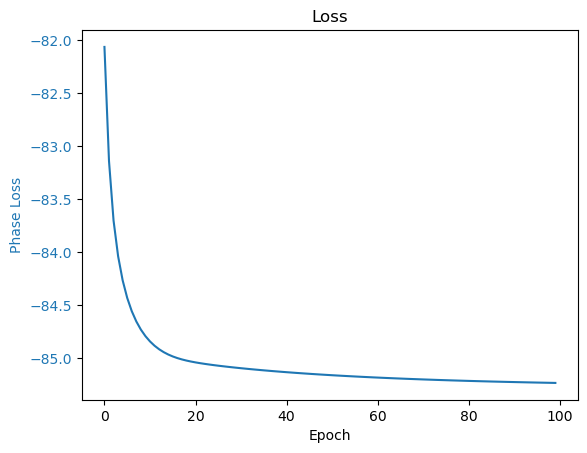

In [22]:
epochs = list(metrics_pha.keys())
loss_vals = [metrics_pha[e]['loss'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Phase Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

plt.title("Loss")
plt.show()

In [23]:
one_hot_states = jnp.eye(visible_units, dtype=jnp.float32)  # one-hot states for visible units

variables_pha_trained = { "params": state_pha.params, "amp": amp_vars }
phases_model_raw = model_pha.apply(variables_pha_trained, one_hot_states, method=model_pha.compute_phase)

phases_model_wrapped = phases_model_raw % (2 * jnp.pi)

phases_model_tuple = list(zip(one_hot_states, phases_model_raw, phases_model_wrapped))

for state, phase_raw, phase_wrapped in phases_model_tuple:
    bitstring = ''.join('1' if s > 0 else '0' for s in state)
    print(f"{bitstring}: {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

1000000000: 8.9684 (raw), 2.6853 (wrapped)
0100000000: 6.2546 (raw), 6.2546 (wrapped)
0010000000: 8.8306 (raw), 2.5475 (wrapped)
0001000000: 7.2535 (raw), 0.9703 (wrapped)
0000100000: 5.7066 (raw), 5.7066 (wrapped)
0000010000: 6.2169 (raw), 6.2169 (wrapped)
0000001000: 6.9825 (raw), 0.6993 (wrapped)
0000000100: 6.4414 (raw), 0.1582 (wrapped)
0000000010: 9.0785 (raw), 2.7954 (wrapped)
0000000001: 7.6655 (raw), 1.3823 (wrapped)


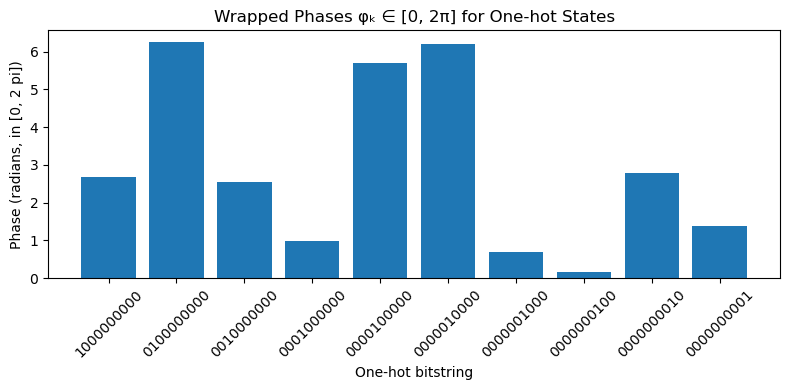

In [24]:
bitstrings = [''.join('1' if val > 0.5 else '0' for val in row) for row in one_hot_states]
phases_np = np.array(phases_model_wrapped)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(bitstrings, phases_np)
ax.set_xlabel("One-hot bitstring")
ax.set_ylabel("Phase (radians, in [0, 2 pi])")
ax.set_title("Wrapped Phases φₖ ∈ [0, 2π] for One-hot States")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

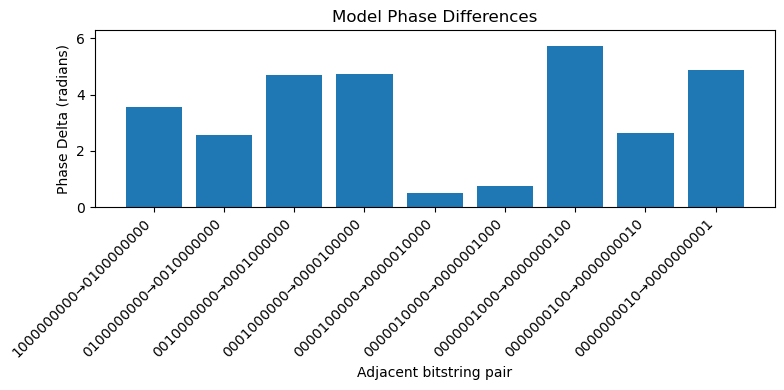

In [25]:

delta = (phases_np[1:] - phases_np[:-1]) % (2*np.pi)
edge_labels = [f"{bitstrings[j]}→{bitstrings[j+1]}" for j in range(len(delta))]

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(edge_labels, delta)
ax.set_ylabel("Phase Delta (radians)")
ax.set_xlabel("Adjacent bitstring pair")
ax.set_title("Model Phase Differences")
plt.xticks(rotation=45, ha="right")
ax.set_ylim(0, 2 * np.pi)
plt.tight_layout()
plt.show()

In [18]:
def load_state_vector_txt(file_path: Path) -> dict:
    state_dict = {}
    with open(file_path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            bitstring, rest = line.strip().split(": ")
            complex_str = rest.split(" + ")[0]
            state_dict[bitstring] = complex(complex_str)
    return state_dict


data_dir = Path("data")
file_path_txt = data_dir / "w_aug_state.txt"
state_vector_dict = load_state_vector_txt(file_path_txt)

# use bitstrings to access all one-hot states
reference_amplitudes = [state_vector_dict[bs] for bs in bitstrings]
reference_phases_raw = np.angle(reference_amplitudes)  # get raw phases in radians
reference_phases_wrapped = reference_phases_raw % (2 * jnp.pi)
bitstring_amplitude_pairs = list(zip(bitstrings, reference_amplitudes, reference_phases_raw, reference_phases_wrapped))

# Display the bitstrings and their corresponding phases
for bitstring, amp, phase_raw, phase_wrapped in bitstring_amplitude_pairs:
    print(f"{bitstring}: ampl: {amp:.4f} (ampl), {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

1000000000: ampl: 0.0474-0.3127j (ampl), -1.4203 (raw), 4.8629 (wrapped)
0100000000: ampl: -0.2932+0.1185j (ampl), 2.7576 (raw), 2.7576 (wrapped)
0010000000: ampl: 0.1994-0.2454j (ampl), -0.8885 (raw), 5.3947 (wrapped)
0001000000: ampl: -0.1027-0.2991j (ampl), -1.9015 (raw), 4.3817 (wrapped)
0000100000: ampl: 0.2625+0.1764j (ampl), 0.5917 (raw), 0.5917 (wrapped)
0000010000: ampl: 0.3125-0.0482j (ampl), -0.1532 (raw), 6.1300 (wrapped)
0000001000: ampl: 0.0221-0.3155j (ampl), -1.5008 (raw), 4.7824 (wrapped)
0000000100: ampl: 0.0710-0.3081j (ampl), -1.3442 (raw), 4.9390 (wrapped)
0000000010: ampl: 0.2192+0.2279j (ampl), 0.8050 (raw), 0.8050 (wrapped)
0000000001: ampl: -0.3010+0.0970j (ampl), 2.8299 (raw), 2.8299 (wrapped)


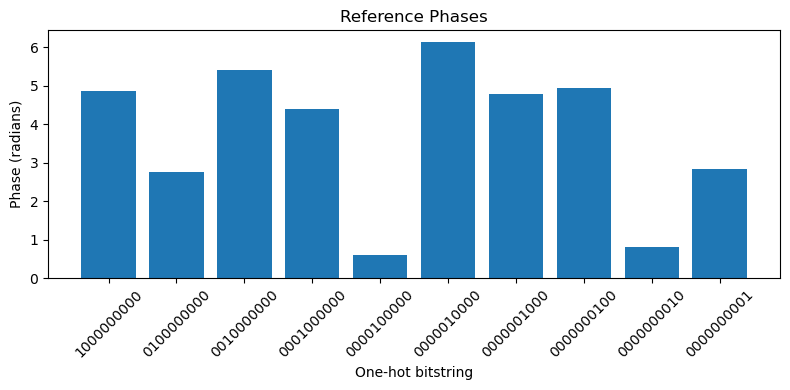

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(bitstrings, reference_phases_wrapped)
ax.set_xlabel("One-hot bitstring")
ax.set_ylabel("Phase (radians)")
ax.set_title("Reference Phases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

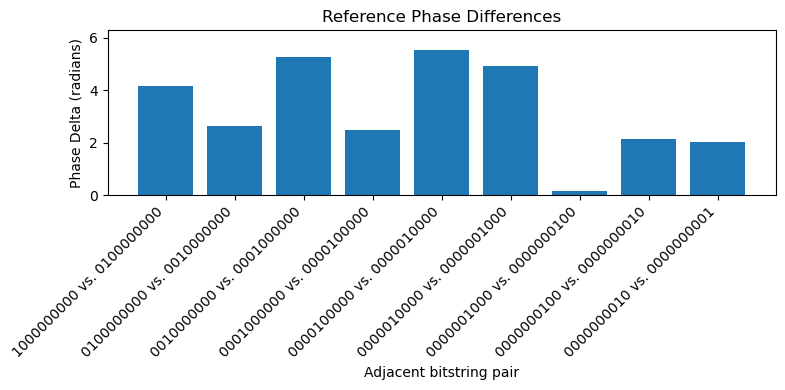

In [26]:

delta = (reference_phases_wrapped[1:] - reference_phases_wrapped[:-1]) % (2*np.pi)
edge_labels = [f"{bitstrings[j]} vs. {bitstrings[j+1]}" for j in range(len(delta))]

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(edge_labels, delta)
ax.set_ylabel("Phase Delta (radians)")
ax.set_xlabel("Adjacent bitstring pair")
ax.set_title("Reference Phase Differences")
plt.xticks(rotation=45, ha="right")
ax.set_ylim(0, 2 * np.pi)
plt.tight_layout()
plt.show()